Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    country             market   admin_1  longitude  latitude     cpcv2  \
0  Zimbabwe  Bulawayo, Renkini  Bulawayo    28.5734  -20.1471  P33360AA   
1  Zimbabwe  Bulawayo, Renkini  Bulawayo    28.5734  -20.1471  P33360AA   
2  Zimbabwe  Bulawayo, Renkini  Bulawayo    28.5734  -20.1471  P33360AA   
3  Zimbabwe  Bulawayo, Renkini  Bulawayo    28.5734  -20.1471  P33360AA   
4  Zimbabwe  Bulawayo, Renkini  Bulawayo    28.5734  -20.1471  P33360AA   

  product                                    source_document period_date  \
0  Diesel  Famine Early Warning Systems Network (FEWS NET...  2009-01-31   
1  Diesel  Famine Early Warning Systems Network (FEWS NET...  2009-02-28   
2  Diesel  Famine Early Warning Systems Network (FEWS NET...  2009-03-31   
3  Diesel  Famine Early Warning Systems Network (FEWS NET...  2009-04-30   
4  Diesel  Famine Early Warning Systems 

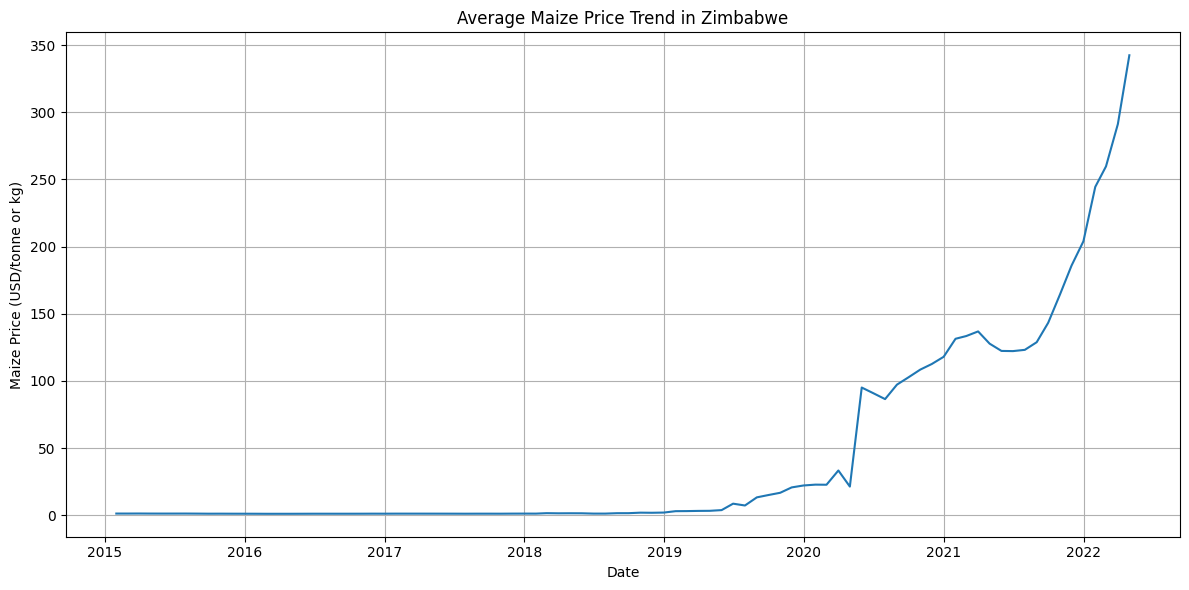

ADF Statistic: 5.957467323511307
p-value: 1.0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible sta

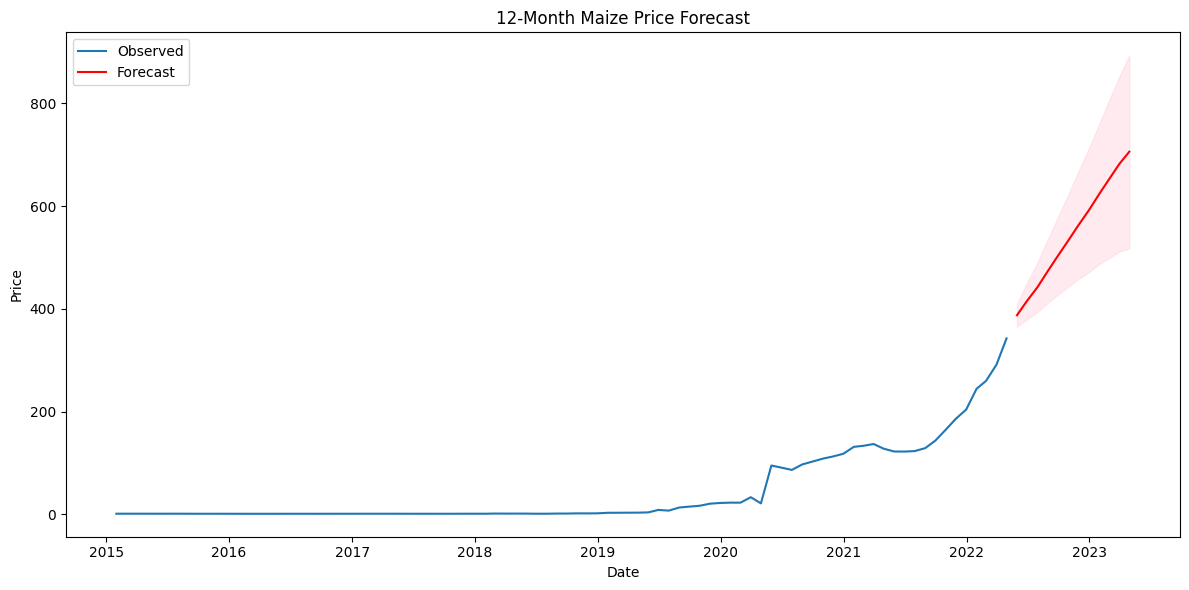

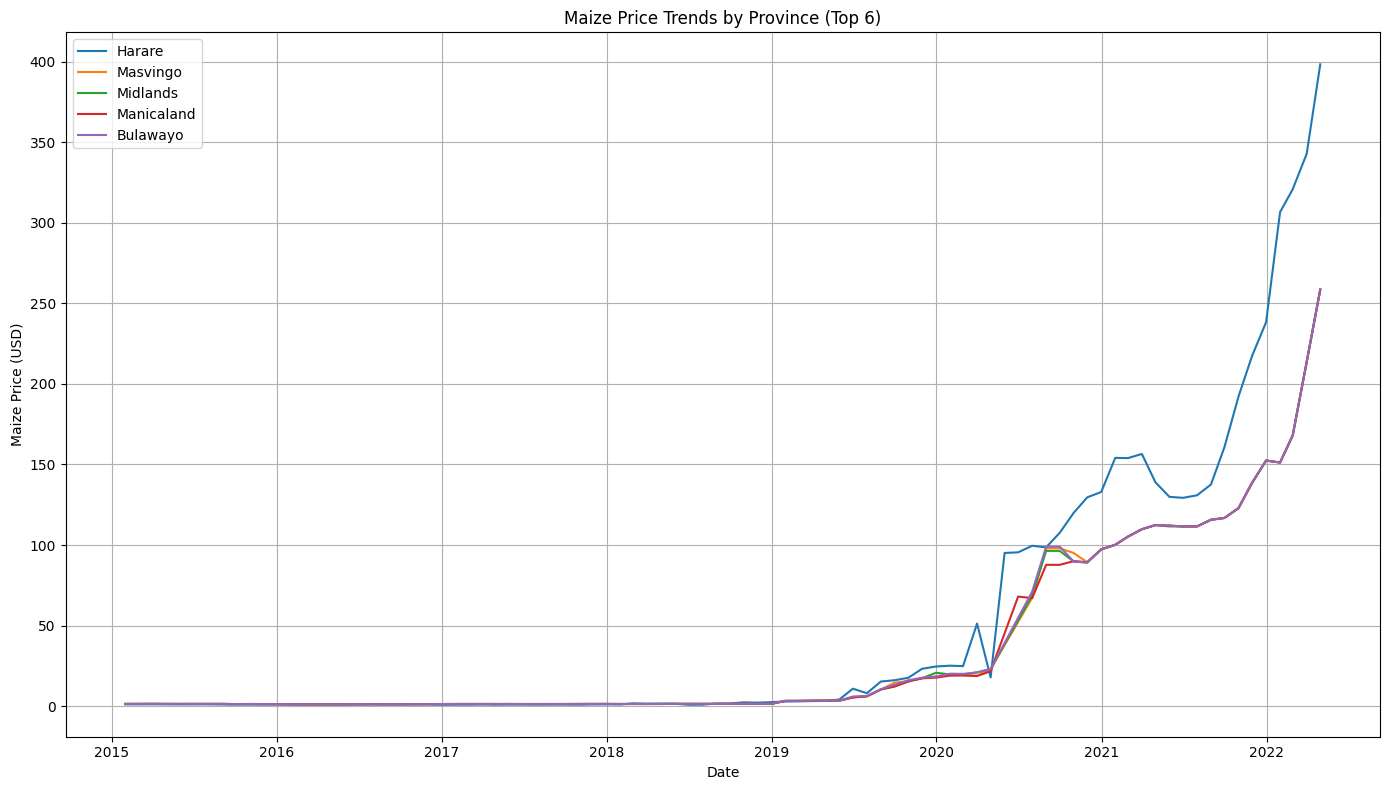

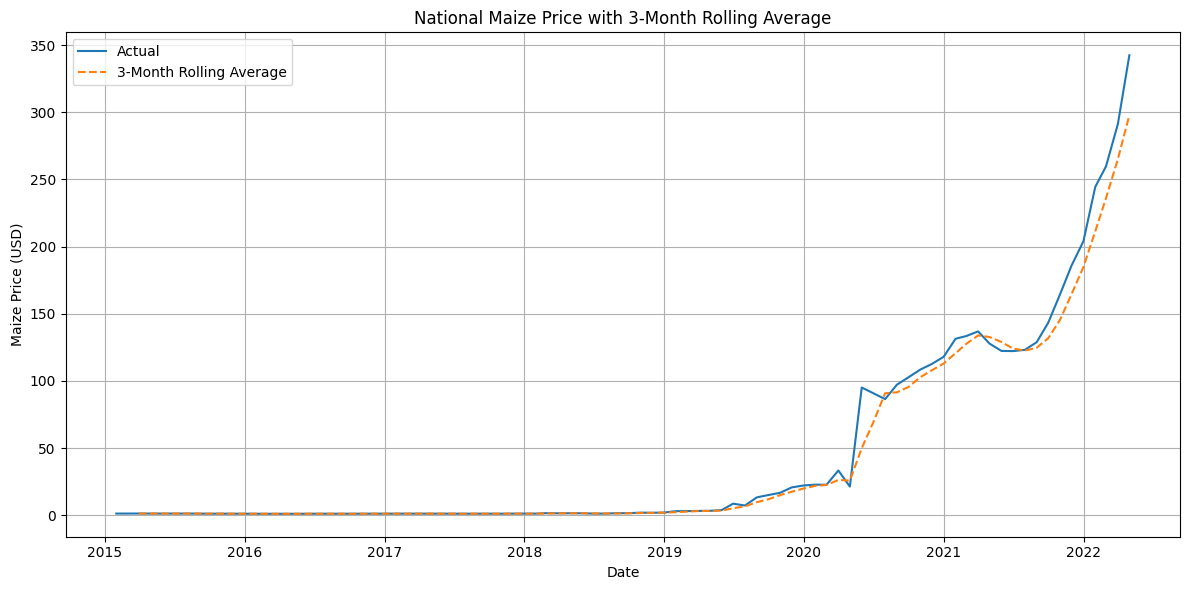

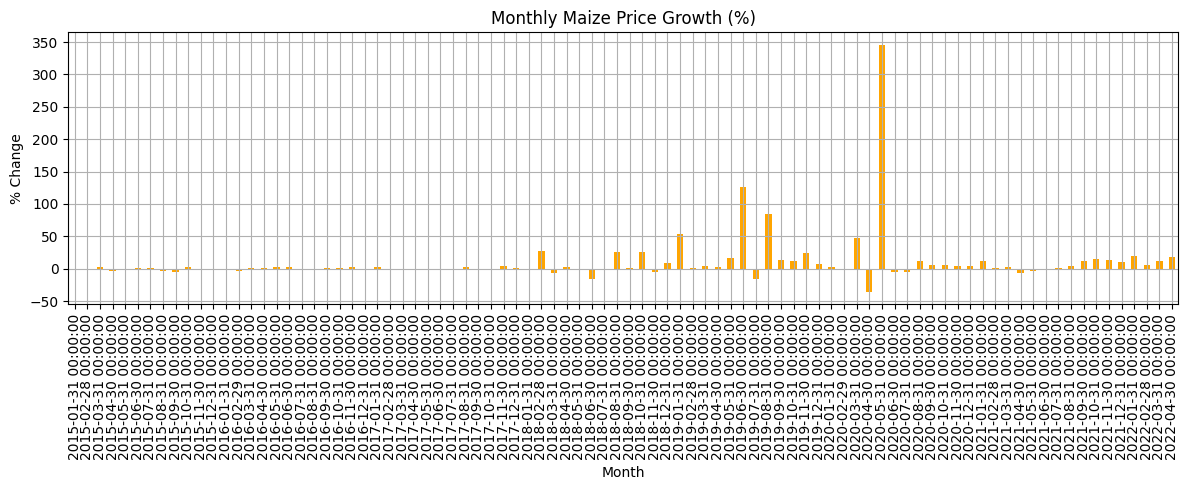

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
maize_path = "/content/drive/My Drive/FEWS_NET_Staple_Food_Price_Data.csv"
df_maize = pd.read_csv(maize_path)
# Import necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np


# Explore and clean
print(df_maize.head())
print(df_maize.info())
print(df_maize.columns)
# Optional: Rename columns for consistency

# Select only the necessary columns and then rename them
#df_maize = df_maize[['date', 'admin1', 'price']].copy() # Assuming 'date', 'admin1', and 'price' are the original column names for Date, Province, and Maize_Price respectively. You might need to adjust these based on your actual CSV file.
df_maize = df_maize[['period_date', 'admin_1','value']].copy()

# Ensure you are using df_maize, not df
df_maize['period_date'] = pd.to_datetime(df_maize['period_date'])
# Convert Date column to datetime
df_maize['period_date'] = pd.to_datetime(df_maize['period_date'])

# Remove missing or zero prices
df_maize = df_maize[df_maize['value'].notna()]
df_maize = df_maize[df_maize['value'] > 0]

#  Filter to recent years only (e.g. from 2015)
df_maize = df_maize[df_maize['period_date'] >= '2015-01-01']


# Group by Date and average across provinces
monthly_prices = df_maize.groupby('period_date')['value'].mean().reset_index()
if monthly_prices['value'].isnull().any():
  monthly_prices.dropna(inplace=True)
# Plot price trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_prices, x='period_date', y='value')
plt.title('Average Maize Price Trend in Zimbabwe')
plt.xlabel('Date')
plt.ylabel('Maize Price (USD/tonne or kg)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for stationarity (ADF Test)
result = adfuller(monthly_prices['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Make data stationary if needed
monthly_prices.set_index('period_date', inplace=True)
monthly_prices_diff = monthly_prices.diff().dropna()

# Fit SARIMA Model
model = SARIMAX(monthly_prices, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast future prices
forecast = results.get_forecast(steps=12)
forecast_df = forecast.summary_frame()
forecast_df.index.name = 'Date'

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices, label='Observed')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.title('12-Month Maize Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


# Plot price trend by province (top 6 with most data)
top_provinces = df_maize['admin_1'].value_counts().head(6).index

plt.figure(figsize=(14, 8))
for province in top_provinces:
    province_data = df_maize[df_maize['admin_1'] == province]
    province_avg = province_data.groupby('period_date')['value'].mean()
    plt.plot(province_avg, label=province)

plt.title('Maize Price Trends by Province (Top 6)')
plt.xlabel('Date')
plt.ylabel('Maize Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Add 3-month rolling average to national trend
monthly_prices['Rolling_3M'] = monthly_prices['value'].rolling(window=3).mean()

# Plot smoothed vs actual
plt.figure(figsize=(12, 6))
plt.plot(monthly_prices.index, monthly_prices['value'], label='Actual')
plt.plot(monthly_prices.index, monthly_prices['Rolling_3M'], label='3-Month Rolling Average', linestyle='--')
plt.title('National Maize Price with 3-Month Rolling Average')
plt.xlabel('Date')
plt.ylabel('Maize Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate monthly percent change
monthly_prices['Monthly_Growth_%'] = monthly_prices['value'].pct_change() * 100

# Plot monthly growth
plt.figure(figsize=(12, 5))
monthly_prices['Monthly_Growth_%'].plot(kind='bar', color='orange')
plt.title('Monthly Maize Price Growth (%)')
plt.ylabel('% Change')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()


readme_text = """
# Zimbabwe Maize Market Analysis for Food Security

This project analyzes maize price trends in Zimbabwe and forecasts future prices using time series modeling. It also compares price changes across provinces and calculates monthly price growth. The analysis is tailored for food security insights, aligning with the goals of organizations such as the World Food Programme (WFP).

---

## Project Objectives

- Analyze maize price trends nationally and by province.
- Forecast prices using SARIMA time series modeling.
- Calculate monthly price growth rates.
- Support data-driven food security and market monitoring decisions.

---

## Dataset

- Source: Market monitoring dataset from FEWS NET and public repositories.
- Fields: `period_date`, `admin_1` (province), `value` (maize price in USD).
- Range: 2015–2024 (filtered for clean forecasting).

---

## Key Analyses

1. National Maize Price Trend
2. Provincial Price Comparisons
3. 3-Month Rolling Average Smoothing
4. Monthly Growth Rate Calculation
5. 12-Month Price Forecast (SARIMA Model)

---

## Tech Stack

- Python (Pandas, Matplotlib, Seaborn, Statsmodels)
- Jupyter/Colab
- Time Series Modeling (SARIMA)
- Data Visualization and Cleaning

---

## Visual Insights

- Line plots of national and provincial maize price trends
- Rolling averages to show smoothed patterns
- Bar chart of monthly % growth in price
- 12-month future forecast with confidence intervals

---

## How to Run This Notebook

1. Upload your dataset (e.g., `maize_prices.csv`)
2. Run each section in sequence
3. SARIMA forecast may require tweaking if data structure changes

---

## Forecast Interpretation

- Forecasts indicate continued maize price increases into the next year.
- Wide confidence intervals reflect price volatility, useful for early warning systems.
- Regional disparities suggest localized market behavior that requires targeted interventions.

---

## Author

**Vanessa Chinhengo**
Financial Mathematics Graduate | Data Enthusiast | Community Builder
[LinkedIn](https://linkedin.com/in/vanessachinhengo)
vanessachinhengo@gmail.com
"""

# Save README to a local file in Colab
with open("README.md", "w") as file:
    file.write(readme_text)

# Download it to your phone
from google.colab import files
files.download("README.md")


requirements = """
pandas
matplotlib
seaborn
statsmodels
scikit-learn
"""

# Save to file
with open("requirements.txt", "w") as file:
    file.write(requirements)

# Download to device
from google.colab import files
files.download("requirements.txt")